1 iteration:
    KNN - Best k: 13, Errors: {'train': 0.16000000000000003, 'val': 0.19999999999999996, 'test': 0.28}
    SVM - Best c: 100, Errors: {'train': 0.0, 'val': 0.16000000000000003, 'test': 0.13}
    error rate bound: 0.38
Train Data error bound 0.38
Train Data vc_bound 10.729244553551004
Validation Data error bound 0.38
Validation Data vc_bound 5.019596139324892
Test Data error bound 0.019
Test Data vc_bound 5.013748760093079
2 iteration:
    KNN - Best k: 4, Errors: {'train': 0.21999999999999997, 'val': 0.19999999999999996, 'test': 0.32099999999999995}
    SVM - Best c: 100, Errors: {'train': 0.0, 'val': 0.19999999999999996, 'test': 0.15700000000000003}
    error rate bound: 0.36
Train Data error bound 0.36
Train Data vc_bound 14.813652658478286
Validation Data error bound 0.36
Validation Data vc_bound 10.57206989613665
Test Data error bound 0.018
Test Data vc_bound 4.41067502953371
3 iteration:
    KNN - Best k: 5, Errors: {'train': 0.16000000000000003, 'val': 0.219999999999

/var/folders/81/qgbbmj9x18352k83sb6q07_c0000gn/T/ipykernel_21542/1551957638.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
/var/folders/81/qgbbmj9x18352k83sb6q07_c0000gn/T/ipykernel_21542/1551957638.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(
/var/folders/81/qgbbmj9x18352k83sb6q07_c0000gn/T/ipykernel_21542/1551957638.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(


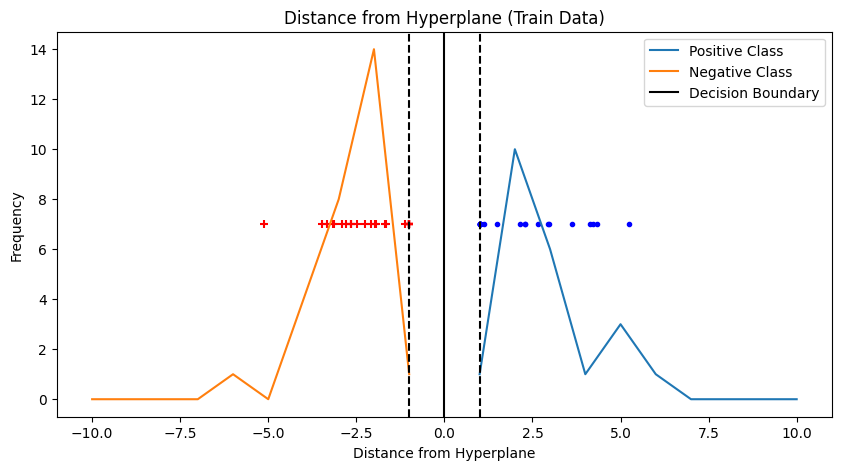

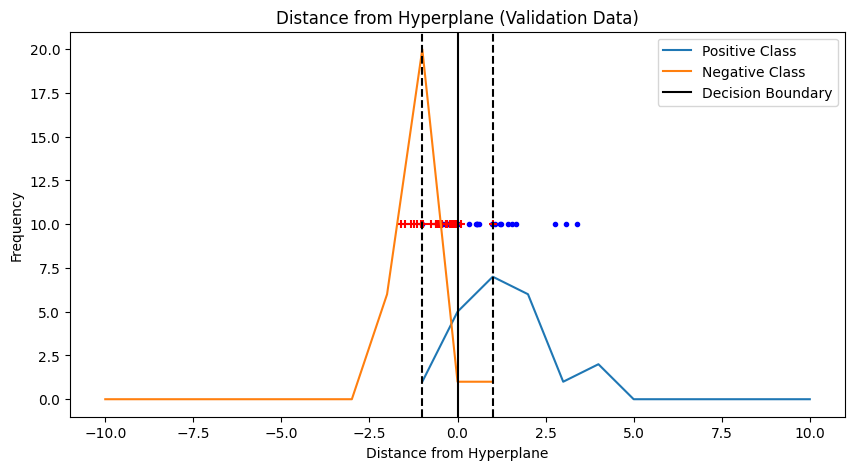

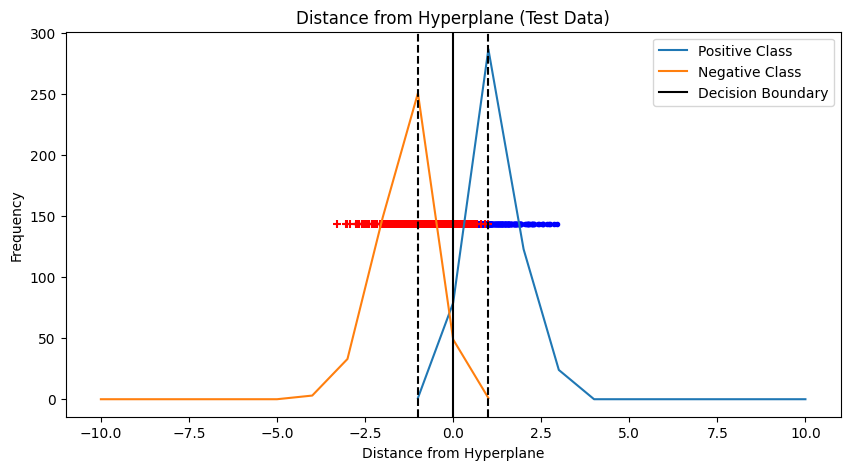

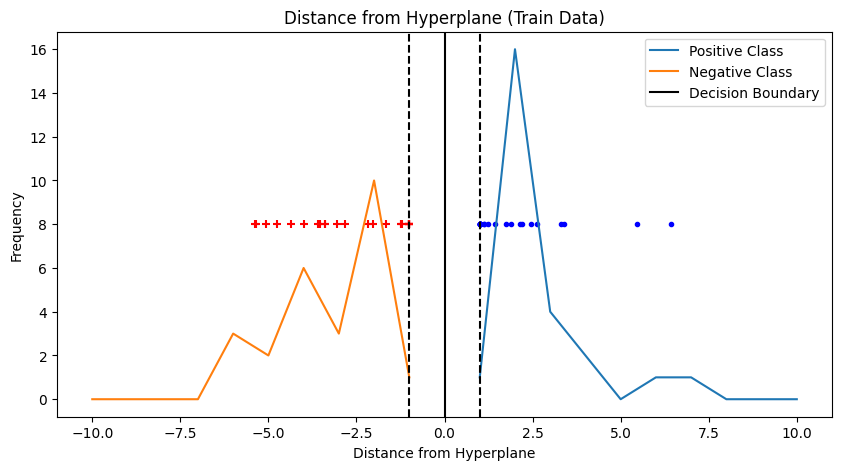

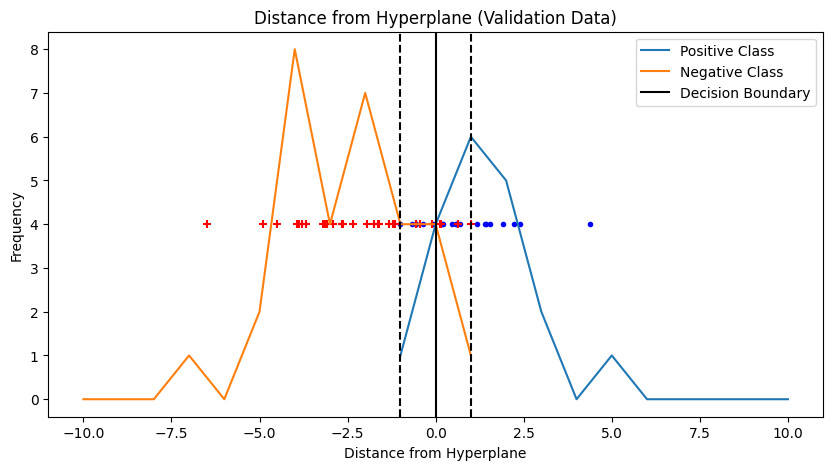

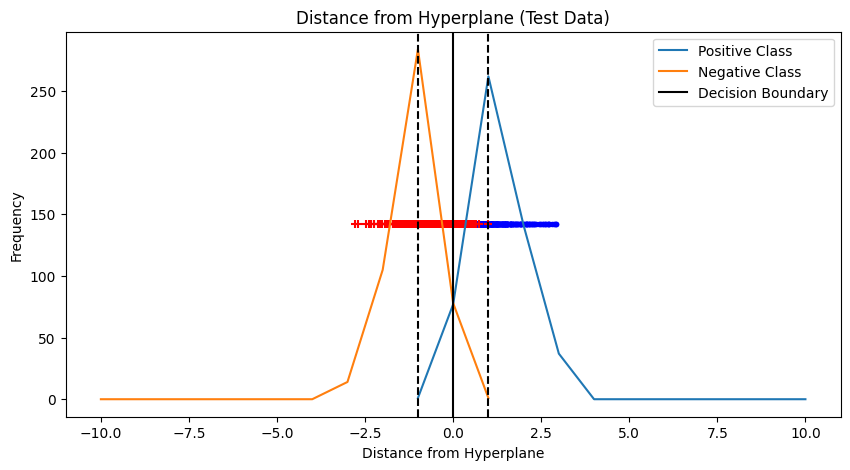

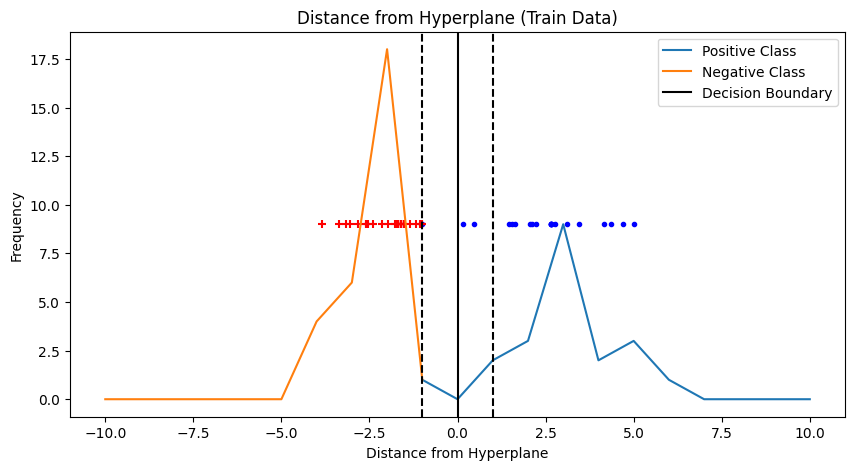

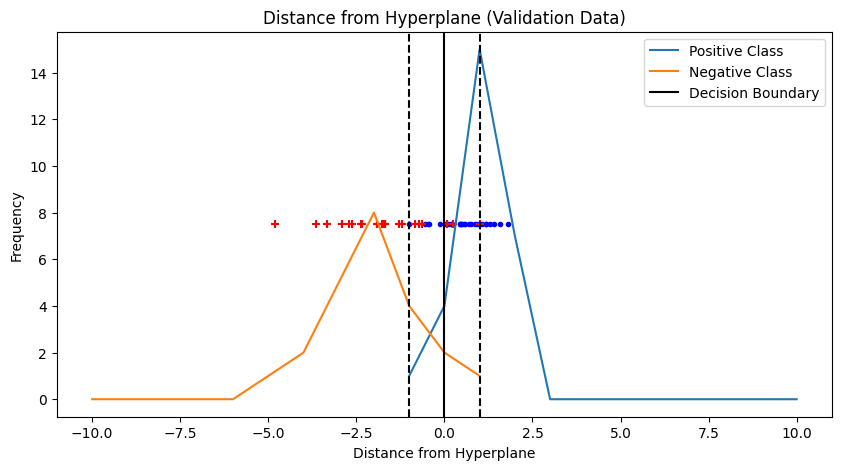

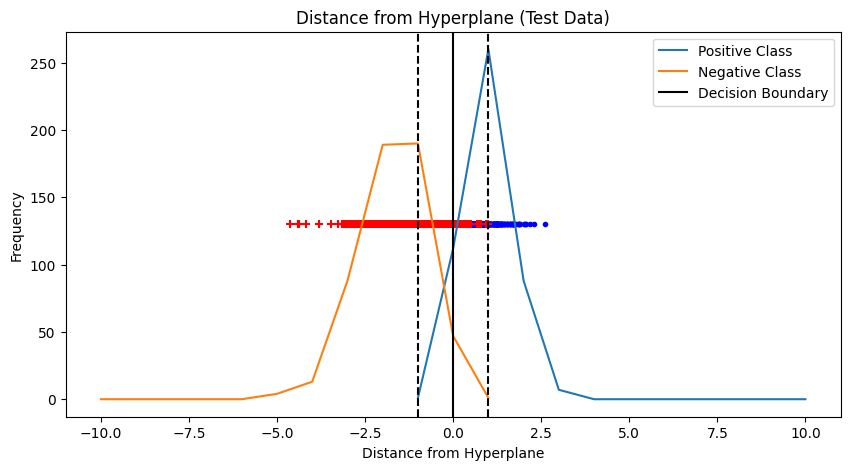

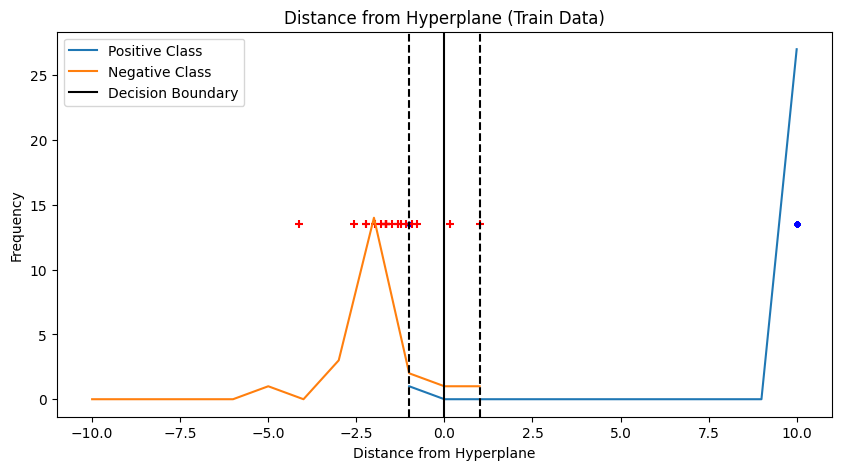

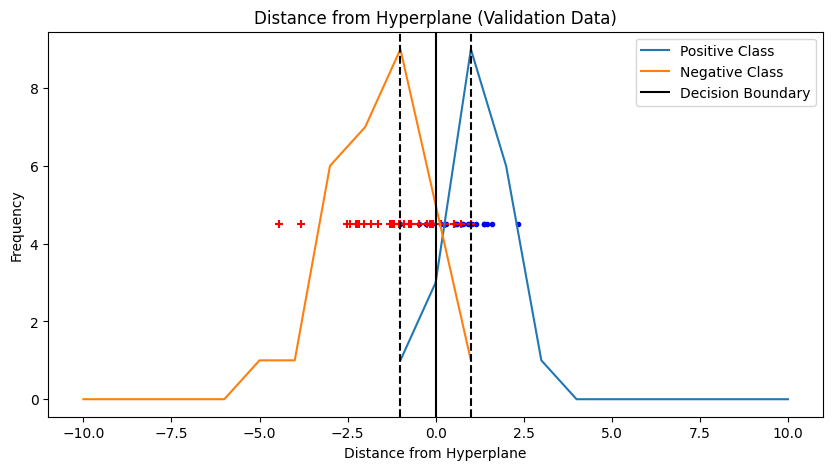

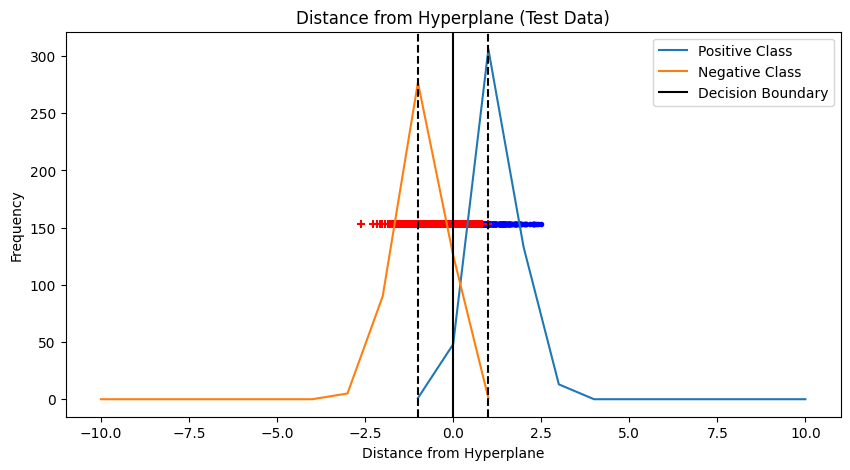

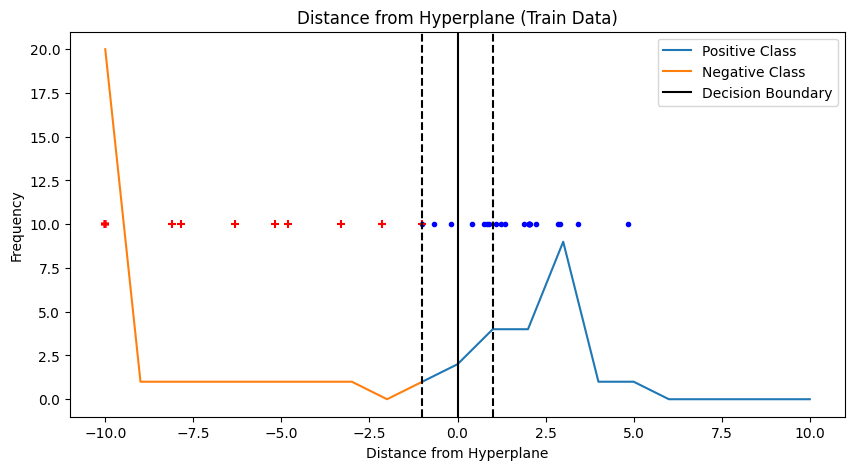

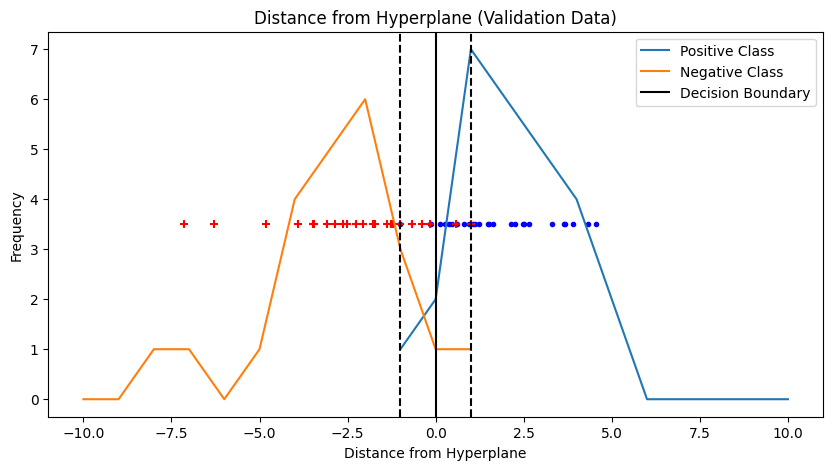

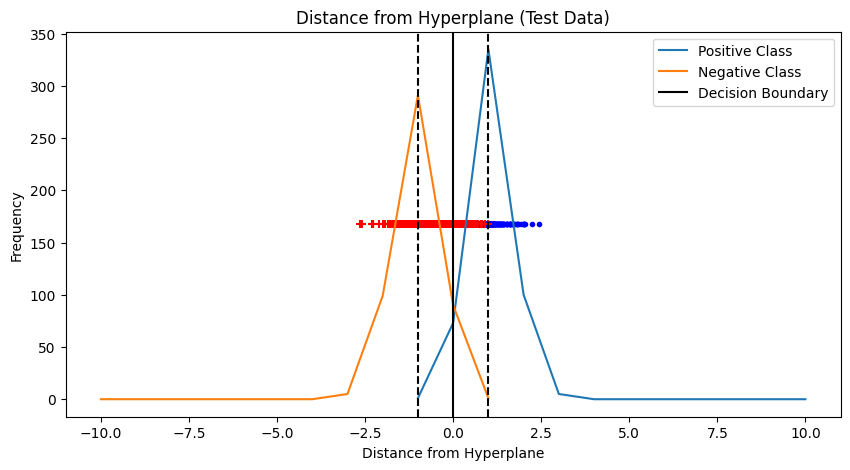

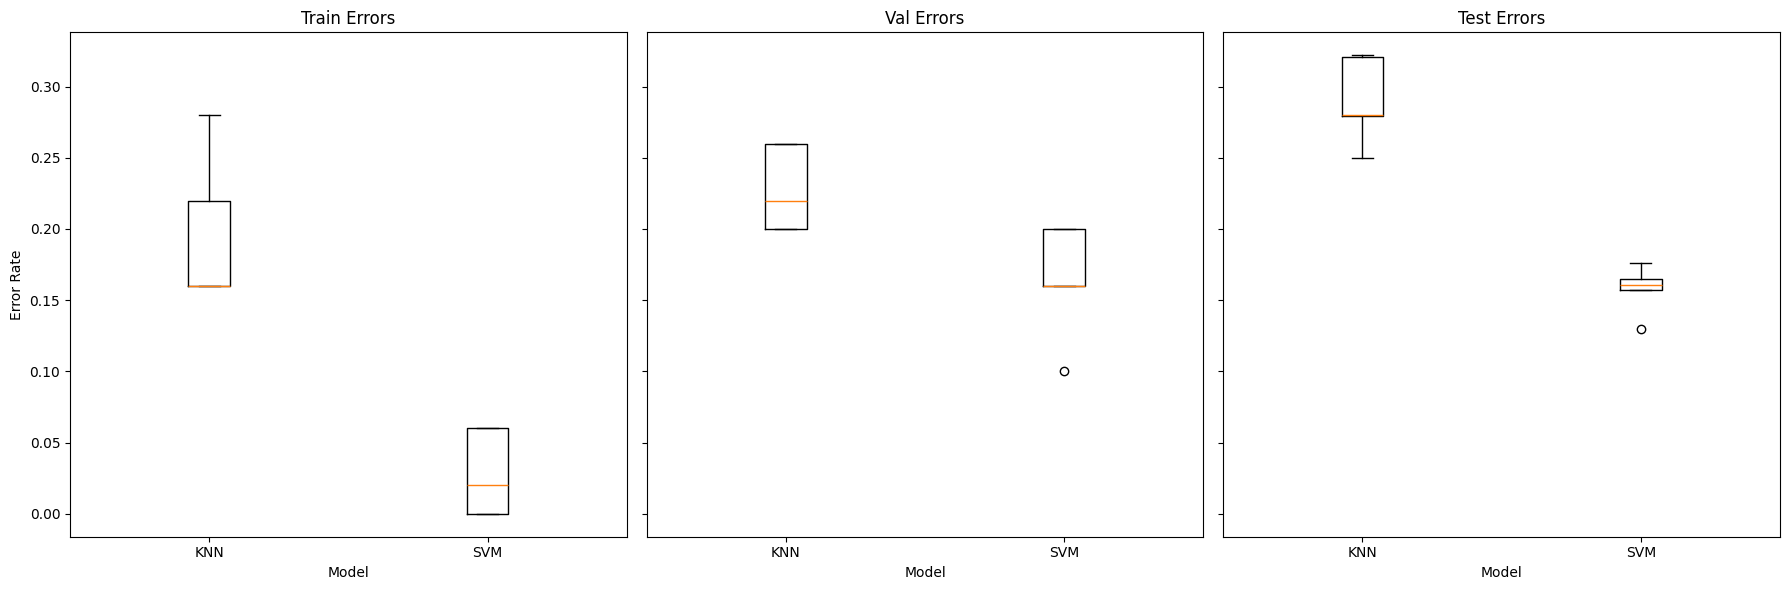

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



def generate_data(n_samples):
    X = np.random.uniform(0, 1, (n_samples, 20))
    y = np.sign(np.sum(X[:, :10], axis=1) - 5) 
    return X, y


def knn_model(X_train, y_train, X_val, y_val, X_test, y_test):
    best_k = None
    best_val_acc = 0
    for k in range(1,21): # Tuning param
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        val_acc = accuracy_score(y_val, knn.predict(X_val))
        if val_acc > best_val_acc:
            best_k = k
            best_val_acc = val_acc
    
    knn_best = KNeighborsClassifier(n_neighbors=best_k)
    knn_best.fit(X_train, y_train)
    # knn_test_acc = accuracy_score(y_test, knn_best.predict(X_test))
    errors = {}
    errors["train"] = 1 - accuracy_score(y_train, knn_best.predict(X_train))
    errors["val"] = 1 - best_val_acc
    errors["test"] = 1 - accuracy_score(y_test, knn_best.predict(X_test))


    return best_k, errors


def svm_model(X_train, y_train, X_val, y_val, X_test, y_test):
    best_c = None
    best_val_acc = 0
    for c in [0.1, 1, 10, 100]:  # Test different regularization parameters
        svm = SVC(C=c, kernel='linear')
        svm.fit(X_train, y_train)
        val_acc = accuracy_score(y_val, svm.predict(X_val))
        if val_acc > best_val_acc:
            best_c = c
            best_val_acc = val_acc

    svm_best = SVC(C=best_c, kernel='linear')
    svm_best.fit(X_train, y_train)
    errors = {}
    errors["train"] = 1 - accuracy_score(y_train, svm_best.predict(X_train))
    errors["val"] = 1 - best_val_acc
    errors["test"] = 1 - accuracy_score(y_test, svm_best.predict(X_test))

    num_support_vectors = len(svm_best.support_)
    n_samples = len(X_train)
    error_rate_bound = num_support_vectors / n_samples

    return best_c, errors, num_support_vectors, error_rate_bound


def get_min_max_distance(X, Y, svm):
    X_pos = X[Y == 1]
    X_neg = X[Y == -1]
    distance_pos = svm.decision_function(X_pos)
    distance_neg = svm.decision_function(X_neg)
    return (
        abs(np.max(distance_pos)),
        abs(np.min(distance_pos)),
        abs(np.max(distance_neg)),
        abs(np.min(distance_neg)),
    )

def split_data_get_dis_count(X, Y, svm, min_distance_pos, max_distance_neg):
    X_pos = X[Y == 1]
    X_neg = X[Y == -1]
    # clipped value to -10, 10
    distance_pos = np.clip(svm.decision_function(X_pos) / min_distance_pos, -10, 10)
    distance_neg = np.clip(svm.decision_function(X_neg) / max_distance_neg, -10, 10)

    # Round distances
    distance_pos_round = list(map(lambda x: math.ceil(x), distance_pos))
    distance_neg_round = list(map(lambda x: math.floor(x), distance_neg))

    # Bin counts
    distance_pos_count = [0] * 21
    distance_neg_count = [0] * 21

    for dis in distance_pos_round:
        distance_pos_count[int(dis + 10)] += 1
    for dis in distance_neg_round:
        distance_neg_count[int(dis + 10)] += 1

    mean = max(distance_pos_count + distance_neg_count) / 2

    # Replace zero counts with NaN for clean visualization
    for i in range(21):
        if distance_pos_count[i] == 0:
            distance_pos_count[i] = np.nan
        else:
            break
    for i in range(20, -1, -1):
        if distance_neg_count[i] == 0:
            distance_neg_count[i] = np.nan
        else:
            break

    return distance_pos, distance_neg, distance_pos_count, distance_neg_count, mean

def plot_error_boxplots(knn_errors, svm_errors):
    error_types = ["train", "val", "test"]
    fig, axes = plt.subplots(1, len(error_types), figsize=(18, 6), sharey=True)

    for i, error_type in enumerate(error_types):
        axes[i].boxplot(
            [knn_errors[error_type], svm_errors[error_type]],
            labels=["KNN", "SVM"]
        )
        axes[i].set_title(f"{error_type.capitalize()} Errors")
        axes[i].set_ylabel("Error Rate" if i == 0 else "")  # Label only the first subplot's Y-axis
        axes[i].set_xlabel("Model")

    plt.tight_layout()
    plt.show()



def histogram_of_projections(X_train, y_train, X_test, y_test, X_val, y_val, c):
    svm = SVC(C=c, kernel='linear')
    svm.fit(X_train, y_train)

    num_support_vectors = len(svm.support_)
    n_samples = len(X_train)
    error_rate_bound = num_support_vectors / n_samples



    def plot_data(X, y, dataset_name):
        max_distance_pos, min_distance_pos, max_distance_neg, min_distance_neg = get_min_max_distance(X, y, svm)

        #### Analytic Bound 

        num_support_vectors = len(svm.support_)
        n_samples = len(X)
        error_rate_bound = num_support_vectors / n_samples

        print(f"{dataset_name} error bound", error_rate_bound)

        r = max_distance_pos + max_distance_neg
        delta = min_distance_pos + max_distance_neg
        d = 20
        vc_bound = min((r**2 / delta**2), d) + 1

        print(f"{dataset_name} vc_bound", vc_bound)

        distances_pos, distances_neg, count_pos, count_neg, mean = split_data_get_dis_count(
            X, y, svm, min_distance_pos, max_distance_neg
        )

        plt.figure(figsize=(10, 5))
        range_list = np.arange(-10, 11, 1)

        # Plot
        plt.title(f"Distance from Hyperplane ({dataset_name})")
        plt.plot(range_list, count_pos, label="Positive Class")
        plt.plot(range_list, count_neg, label="Negative Class")
        plt.scatter(distances_pos, [mean] * len(distances_pos), c="b", marker=".")
        plt.scatter(distances_neg, [mean] * len(distances_neg), c="r", marker="+")
        plt.axvline(x=0, color="black", label="Decision Boundary")
        plt.axvline(x=-1, color="black", linestyle="--")
        plt.axvline(x=1, color="black", linestyle="--")
        plt.xlabel("Distance from Hyperplane")
        plt.ylabel("Frequency")
        plt.legend()


    plot_data( X_train, y_train, "Train Data")
    plot_data( X_val, y_val, "Validation Data")
    plot_data( X_test, y_test, "Test Data")



knn_errors = {"train": [], "val": [], "test": []}
svm_errors = {"train": [], "val": [], "test": []}

for i in range(1,6):
    X_train, y_train = generate_data(50)
    X_val, y_val = generate_data(50)
    X_test, y_test = generate_data(1000)

    best_k, knn_err = knn_model(X_train, y_train, X_val, y_val, X_test, y_test)
    best_c, svm_err, sv_num, error_rate_bound = svm_model(X_train, y_train, X_val, y_val, X_test, y_test)

    


    print(f"{i} iteration:")
    print(f"    KNN - Best k: {best_k}, Errors: {knn_err}")
    print(f"    SVM - Best c: {best_c}, Errors: {svm_err}")
    print(f"    error rate bound: {error_rate_bound}")

    for key in ["train", "val", "test"]:
        knn_errors[key].append(knn_err[key])
        svm_errors[key].append(svm_err[key])

    histogram_of_projections(X_train, y_train, X_test, y_test, X_val, y_val, best_c)
    

plot_error_boxplots(knn_errors, svm_errors)



Analytic Prescription for C: 96.6765


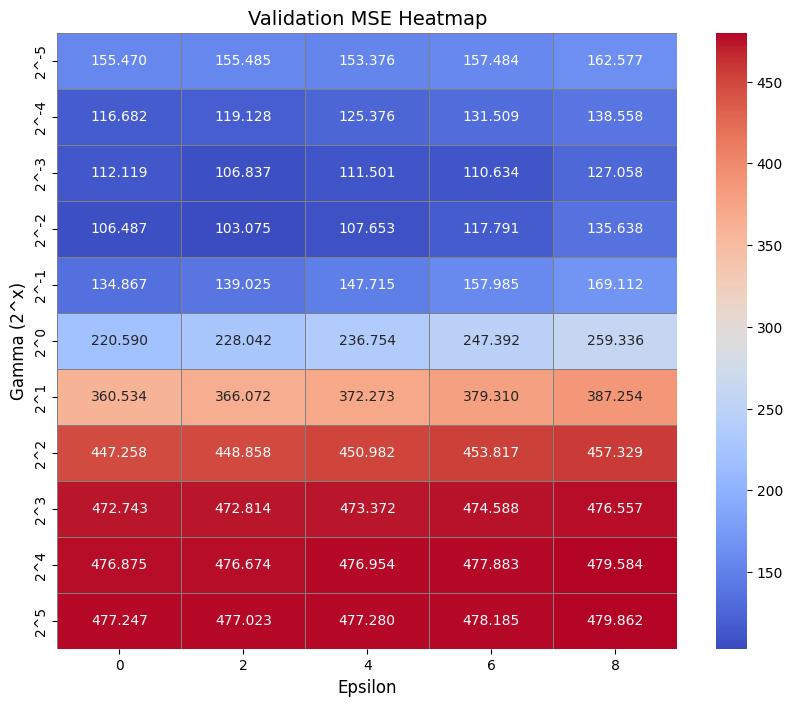


Validation MSE Table:
            0        2        4        6        8
2^-5  155.470  155.485  153.376  157.484  162.577
2^-4  116.682  119.128  125.376  131.509  138.558
2^-3  112.119  106.837  111.501  110.634  127.058
2^-2  106.487  103.075  107.653  117.791  135.638
2^-1  134.867  139.025  147.715  157.985  169.112
2^0   220.590  228.042  236.754  247.392  259.336
2^1   360.534  366.072  372.273  379.310  387.254
2^2   447.258  448.858  450.982  453.817  457.329
2^3   472.743  472.814  473.372  474.588  476.557
2^4   476.875  476.674  476.954  477.883  479.584
2^5   477.247  477.023  477.280  478.185  479.862

Best epsilon: 2, Best gamma: 2^-2

Test MSE: 130.9818
Test NRMSE: 0.0808


In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic regression data
def generate_regression_data(n_samples, noise_std=5):
    X = np.random.uniform(-1.5, 1.5, (n_samples, 6))
    noise = np.random.normal(0, noise_std, n_samples)
    y = (
        10 * np.sin(2 * np.pi * X[:, 0])
        + 20 * (X[:, 1] - 0.5) ** 2
        + 10 * X[:, 2]
        + 5 * X[:, 3]
        + noise
    )
    return X, y

# Analytic prescription for C
def calculate_C(y_train):
    y_mean = np.mean(y_train)
    y_std = np.std(y_train)
    C = max(abs(y_mean + 3 * y_std), abs(y_mean - 3 * y_std))
    return C

# Perform grid search for SVR
def grid_search_svr(X_train, y_train, X_val, y_val, C):
    epsilons = [0, 2, 4, 6, 8]
    gammas = [2 ** i for i in range(-5, 6)]  # gamma = 2^-5 to 2^5
    results = []

    for epsilon in epsilons:
        for gamma in gammas:
            svr = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma)
            svr.fit(X_train, y_train)
            val_predictions = svr.predict(X_val)
            mse = mean_squared_error(y_val, val_predictions)
            results.append((epsilon, gamma, round(mse, 3)))  # Round to 3 decimals
    
    return results, epsilons, gammas

# Create table and heatmap of results
def create_and_display_heatmap(results, epsilons, gammas):
    # Create a DataFrame with gamma as rows and epsilon as columns
    table = pd.DataFrame(index=[f"2^{int(np.log2(g))}" for g in gammas],
                         columns=epsilons, dtype=float)
    
    # Fill the table with MSE values
    for epsilon, gamma, mse in results:
        table.loc[f"2^{int(np.log2(gamma))}", epsilon] = mse

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        table, annot=True, fmt=".3f", cmap="coolwarm",
        cbar=True, linewidths=0.5, linecolor="gray"
    )
    plt.xlabel("Epsilon", fontsize=12)
    plt.ylabel("Gamma (2^x)", fontsize=12)
    plt.title("Validation MSE Heatmap", fontsize=14)
    plt.show()
    
    return table



# Main procedure
def main():
    # Generate datasets
    X_train, y_train = generate_regression_data(100)
    X_val, y_val = generate_regression_data(100)
    X_test, y_test = generate_regression_data(800)

    # Calculate analytic C
    C = calculate_C(y_train)
    print(f"Analytic Prescription for C: {C:.4f}")

    # Perform grid search
    results, epsilons, gammas = grid_search_svr(X_train, y_train, X_val, y_val, C)

    # Create and display heatmap
    results_table = create_and_display_heatmap(results, epsilons, gammas)
    print("\nValidation MSE Table:")
    print(results_table)

    # Find best epsilon and gamma
    best_gamma_label, best_epsilon = results_table.stack().idxmin()
    best_gamma = 2 ** int(best_gamma_label.split("^")[1])  # Convert label back to numeric gamma
    print(f"\nBest epsilon: {best_epsilon}, Best gamma: {best_gamma_label}")

    # Train best model on combined train + validation sets
    X_combined = np.vstack([X_train, X_val])
    y_combined = np.hstack([y_train, y_val])
    svr_best = SVR(kernel="rbf", C=C, epsilon=best_epsilon, gamma=best_gamma)
    svr_best.fit(X_combined, y_combined)

    # Evaluate on the test set
    test_predictions = svr_best.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    y_range = y_test.max() - y_test.min()
    test_nrms = np.sqrt(test_mse) / y_range
    print(f"\nTest MSE: {test_mse:.4f}")
    print(f"Test NRMSE: {test_nrms:.4f}")

if __name__ == "__main__":
    main()

=== SVM Results ===
SVM Test MSE: 147.6057
SVM Test NRMSE: 0.0947

=== PPR Results ===
Best PPR complexity (number of terms): 3

PPR Validation MSE for Different n_terms:
   n_terms  Validation MSE
0        1        147.2626
1        2        110.2119
2        3        103.4241
3        4        130.6009
4        5        142.1161
5        6        154.3535
6        7        167.5644
7        8        215.0651
8        9        395.1485
9       10        247.7296


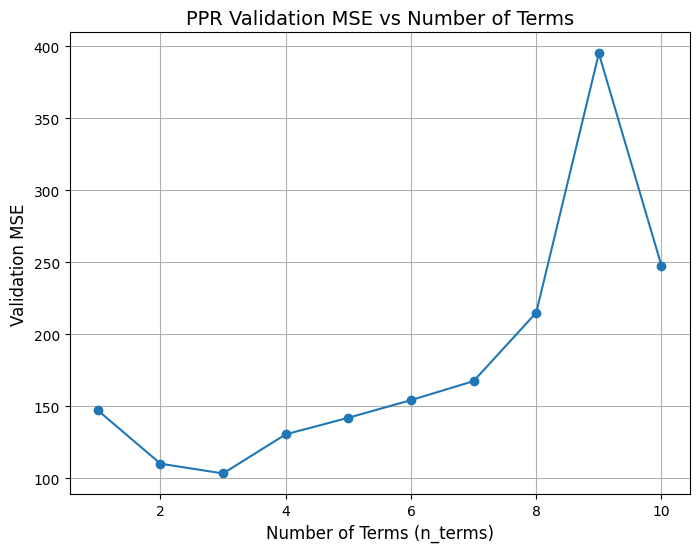


Best PPR complexity (n_terms): 3
PPR Test MSE: 84.9882
PPR Test NRMSE: 0.0718

=== Comparison of SVM and PPR ===
SVM Test MSE: 147.6057, NRMSE: 0.0947
PPR Test MSE: 84.9882, NRMSE: 0.0718
PPR performs better on this dataset, as expected due to its flexibility in capturing non-linear patterns.


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error
from skpp import ProjectionPursuitRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Train Projection Pursuit Regression
def train_ppr(X_train, y_train, X_val, y_val):
    complexity_range = range(1,11)  # Number of terms (complexity parameter)
    best_model = None
    results = []
    best_val_mse = float("inf")
    best_terms = None

    for n_terms in complexity_range:
        ppr = ProjectionPursuitRegressor(r=n_terms)
        ppr.fit(X_train, y_train)
        val_predictions = ppr.predict(X_val)
        val_mse = mean_squared_error(y_val, val_predictions)
        results.append((n_terms, round(val_mse, 4)))

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model = ppr
            best_terms = n_terms

    print(f"Best PPR complexity (number of terms): {best_terms}")
    return best_model, best_terms, results

def display_ppr_results(results):
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=["n_terms", "Validation MSE"])
    print("\nPPR Validation MSE for Different n_terms:")
    print(results_df)

    # Plot results
    plt.figure(figsize=(8, 6))
    plt.plot(results_df["n_terms"], results_df["Validation MSE"], marker="o", linestyle="-")
    plt.xlabel("Number of Terms (n_terms)", fontsize=12)
    plt.ylabel("Validation MSE", fontsize=12)
    plt.title("PPR Validation MSE vs Number of Terms", fontsize=14)
    plt.grid(True)
    plt.show()

def calculate_nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    y_range = np.max(y_true) - np.min(y_true)
    nrmse = rmse / y_range
    return nrmse

# Main procedure
def main():
    # Generate datasets
    X_train, y_train = generate_regression_data(100)
    X_val, y_val = generate_regression_data(100)
    X_test, y_test = generate_regression_data(800)

    # 1. SVM Results (from Part 2a)
    
    print("=== SVM Results ===")
    C = calculate_C(y_train)  # Analytic prescription for C (or use the calculated C from part (a))
    svr_best = SVR(kernel="rbf", C=C, epsilon=4, gamma=0.125)  # Use best params from part (a)
    svr_best.fit(X_train, y_train)
    svm_test_predictions = svr_best.predict(X_test)
    svm_test_mse = mean_squared_error(y_test, svm_test_predictions)
    svm_test_nrmse = calculate_nrmse(y_test, svm_test_predictions)
    print(f"SVM Test MSE: {svm_test_mse:.4f}")
    print(f"SVM Test NRMSE: {svm_test_nrmse:.4f}")

    # 2. PPR Results
    print("\n=== PPR Results ===")
    ppr_best_model, best_terms, ppr_results = train_ppr(X_train, y_train, X_val, y_val)
    display_ppr_results(ppr_results)
    ppr_test_predictions = ppr_best_model.predict(X_test)
    ppr_test_mse = mean_squared_error(y_test, ppr_test_predictions)
    ppr_test_nrmse = calculate_nrmse(y_test, ppr_test_predictions)
    print(f"\nBest PPR complexity (n_terms): {best_terms}")
    print(f"PPR Test MSE: {ppr_test_mse:.4f}")
    print(f"PPR Test NRMSE: {ppr_test_nrmse:.4f}")

    
    # 3. Comparison
    print("\n=== Comparison of SVM and PPR ===")
    print(f"SVM Test MSE: {svm_test_mse:.4f}, NRMSE: {svm_test_nrmse:.4f}")
    print(f"PPR Test MSE: {ppr_test_mse:.4f}, NRMSE: {ppr_test_nrmse:.4f}")

    if ppr_test_mse < svm_test_mse:
        print("PPR performs better on this dataset, as expected due to its flexibility in capturing non-linear patterns.")
    else:
        print("SVM performs better or similarly, which indicates its ability to model this dataset effectively.")

if __name__ == "__main__":
    main()